In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'

Load 200ns Aib9 trajectory

In [3]:
infile = '../../DATA/Train/AIB9/sum_phi_200ns.npy'
input_x = np.load(infile)

bins=np.arange(-15., 17, 1)
num_bins=len(bins)
idx_200ns=np.digitize(input_x, bins)

di=1
N_mean=np.sum(np.abs(idx_200ns[:-di]-idx_200ns[di:])==1)
N_mean/=len(idx_200ns)

N0=len(np.where(idx_200ns<=15)[0])
N1=len(np.where(idx_200ns>=16)[0])
kappa_in = N0/N1

print('kappa:', kappa_in)
print('Nearest neighbor:', N_mean)

kappa: 1.148993438587424
Nearest neighbor: 0.39906640023339995


Check 100ns Aib9 trajectory

In [6]:
idx_100ns = idx_200ns[:2000000]

di=1
N_mean=np.sum(np.abs(idx_100ns[:-di]-idx_100ns[di:])==1)
N_mean/=len(idx_100ns)

N0=len(np.where(idx_100ns<=15)[0])
N1=len(np.where(idx_100ns>=16)[0])
kappa_in = N0/N1

print('kappa:', kappa_in)
print('Nearest neighbor:', N_mean)

kappa: 1.0115786466903496
Nearest neighbor: 0.397483


# Calculate Nearest neighbor $\langle N\rangle$ sampled from the first training

In the first training, we let 800 independent LSTMs predict 800 trajectories of 100$ns$. Since we are using LSTM as a generative model, we can also train just one LSTM and use it to generate 800 predictions, starting from either the same initial condition or different initial conditions.

Data location: `./Output/`

In [29]:
N_mean_list=[]
output_dir='./Output'
for i in range(800):

    pred_dir=os.path.join(output_dir, '{}/prediction.npy'.format(i))
    prediction=np.load(pred_dir)

    di=1
    N_mean=np.sum(np.abs(prediction[:-di]-prediction[di:])==1)
    N_mean/=len(prediction)
    N_mean_list.append(N_mean)
    
N_mean_arr=np.array(N_mean_list)

Plot distribution

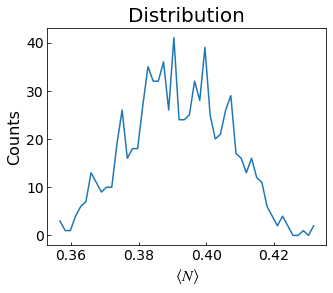

In [30]:
hist = np.histogram( N_mean_arr, bins=50 )
prob = hist[0].T
mids = 0.5*(hist[1][1:]+hist[1][:-1])

fig, ax = plt.subplots(figsize=(5,4))

ax.set_title('Distribution', size=20)
ax.plot(mids, prob)

ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
ax.set_xlabel('$\langle N\\rangle$', size=16)
ax.set_ylabel('Counts', size=16)

plt.show()

# Determine $\Delta\lambda$

Following the reference, we want to solve the following equation for $\Delta\lambda$

\begin{align}
    \bar{s}^{(j)}_2&=\sum_{\Gamma}P^{(2)}_{\Gamma}s^{(j)}_{\Gamma} \nonumber \\
    &=\frac{\sum_{k\in\Omega} s^{(j)}_k e^{-\Delta\lambda_j s^{(j)}_k} }{\sum_{k\in\Omega} e^{-\Delta\lambda_j s^{(j)}_k}} \\
    &=f(\Delta\lambda)
    \label{eq:lambda_solver}
\end{align}


To determine the $\Delta\lambda$ value, we can calculate the above equation and plot it versus $\Delta\lambda$, and find $\Delta\lambda=\Delta\lambda_{\ast}$ which gives 
\begin{align}
\bar{s}^{(j)}_2=f(\Delta\lambda_{\ast})=s^{\rm target}
\end{align}

We would also like to predict the variance of $\bar{s}^{(j)}_2$, which can be obtained through derivative of $f$.
\begin{align}
f'(\lambda)==-\sigma^2_{\bar{s}^{(j)}_2}
\end{align}


### $s = \langle N\rangle$

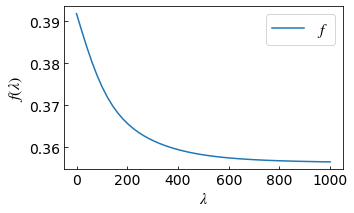

f(62.0) = 0.380072
Standard error stderr[f(0)]=0.000501
df(62.0) = -0.000167
Expected standard error for new N_mean = 0.004084


In [42]:
def f(lm):
    return np.sum(N_mean_arr*np.exp(-lm*N_mean_arr))/np.sum(np.exp(-lm*N_mean_arr))

def df(lm):
    return f(lm)**2-np.sum(N_mean_arr*N_mean_arr*np.exp(-lm*N_mean_arr))/np.sum(np.exp(-lm*N_mean_arr))

lm_arr = np.linspace(0,1000)
f_arr = [f(lm_i) for lm_i in lm_arr]


fig, ax=plt.subplots(figsize=(5,3))

ax.plot(lm_arr, f_arr, label='$f$')

ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
ax.set_xlabel('$\lambda$', size=16)
ax.set_ylabel('$f(\lambda)$', size=16)

ax.legend(fontsize=16)

plt.show()

lm=62
print( 'f({:.1f}) = {:.6f}'.format(lm, f(lm)) )
print( 'Standard error stderr[f(0)]={:.6f}'.format(np.std(N_mean_arr)/np.sqrt(len(N_mean_arr))) )

print( 'df({:.1f}) = {:.6f}'.format(lm, df(lm)) )
print( 'Expected standard error for new N_mean = {:.6f}'.format( np.sqrt(-df(lm))/np.sqrt(10) ) )

So we will constrain our $\kappa$ to 1 with standard error 0.081. Due to small subset we will select, the variance could be large. As a result, we will not stop sampling until we reach a reasonable average value of $\kappa$ of the subset.

In [69]:
lm_ast=62
p=np.exp(-lm_ast*(N_mean_arr))
p/=np.sum(p)

mean=np.inf
stdv=np.inf
while abs(mean-0.380)>0.001 or abs(stdv-0.0041)>0.0001:
    idx = np.random.choice(len(N_mean_arr), 10, p=p)
    selected = N_mean_arr[idx]
    
    mean=np.mean(selected)
    stdv=np.std(selected)/np.sqrt(len(selected))
    
print( 'mean of selected sample = {:.3f}'.format(np.mean(selected)) )
print( 'Standard error stderr[selected sample] = {:.3f}'.format(np.std(selected)/np.sqrt(len(selected))) )

for ki in kappa_arr[idx]:
    print('{:.3f}'.format(ki))

mean of selected sample = 0.380
Standard error stderr[selected sample] = 0.004
0.488
0.270
1.270
0.078
0.099
7.103
0.495
5.780
3.174
3.875


# Concatenate subset as a new training set

Concatenate the subset to a single trajectory, this concatenated trajectory is then used later to re-train a new LSTM.

In [70]:
conc=[]
output_dir='./Output'

for i in idx:
    pred_dir=os.path.join(output_dir, '{}/prediction.npy'.format(i))
    prediction=np.load(pred_dir)
    conc.extend(prediction)
    
conc = np.array(conc)

We can also check what the $\langle N\rangle$ as well as $\kappa$ value of concatenated trajectory is.

In [79]:
N0=len(np.where(conc<=15)[0])
N1=len(np.where(conc>=16)[0])
kappa_conc = N0/N1

di=1
N_mean_conc=np.sum(np.abs(conc[:-di]-conc[di:])==1)
N_mean_conc/=len(conc)


print('kappa:', kappa_conc)
print('Nearest neighbor:', N_mean_conc)

kappa: 0.9525129329575397
Nearest neighbor: 0.37985445
